In [1]:
import math
from math import atan2

import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
data = np.load('../real_data/uscities.npy')

In [3]:
num_nodes = data.shape[0]
num_nodes

1097

In [4]:
dist_mat = cdist(data, data)
dist_mat.shape

(1097, 1097)

In [5]:
k_num = 50
eta = 0.05
added_noise_x = np.random.normal(0, eta*data[:, 0].std(), (num_nodes, k_num))
added_noise_y = np.random.normal(0, eta*data[:, 1].std(), (num_nodes, k_num))
patch_indices = np.argpartition(dist_mat, k_num)[:, :k_num] # k_num=50 nearest neighbors
patch_indices.shape

(1097, 50)

In [5]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [6]:
def get_rotation_matrix(theta):
    
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])

In [8]:
# generate ground-truth rotations for patches using a Gamma distribution
angles_gt = 2 * np.pi * np.random.gamma(shape=0.5, scale=1, size=(num_nodes,)) % (2*np.pi)

In [7]:
def get_rotation(X, Y):
    """
    A part of a port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        angle = get_rotation(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    Outputs
    ------------
    angle 
        an angle of rotation that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    # transformation matrix
    if my < m:
        T = T[:my,:]
    angle = atan2(T[1, 0], T[1, 1])
   
    return angle % (2*np.pi)

In [10]:
num_threshold = 6
adj_obs = np.zeros((num_nodes, num_nodes)) # the observed angular differences matrix
num_edges = 0
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        patch_i = patch_indices[i]
        patch_j = patch_indices[j]
        common_nodes = list(set(patch_i).intersection(set(patch_j)))
        if len(common_nodes) >= num_threshold: # threshold of performing a Procrustes alignment is num_threshold (initially 6) nodes in common
            rot_mat_i = get_rotation_matrix(angles_gt[i]) # rotation matrix
            rot_mat_j = get_rotation_matrix(angles_gt[j])
            noisy_patch_i = data[patch_indices[i]].copy()
            noisy_patch_i[:, 0] += added_noise_x[i]
            noisy_patch_i[:, 1] += added_noise_y[i]
            noisy_patch_j = data[patch_indices[j]].copy()
            noisy_patch_j[:, 0] += added_noise_x[j]
            noisy_patch_j[:, 1] += added_noise_y[j]
            idx_i_sorted = np.argsort(patch_i)
            common_nodes_pos = np.searchsorted(patch_i[idx_i_sorted], common_nodes)
            indices_i = idx_i_sorted[common_nodes_pos]
            idx_j_sorted = np.argsort(patch_j)
            common_nodes_pos = np.searchsorted(patch_j[idx_j_sorted], common_nodes)
            indices_j = idx_j_sorted[common_nodes_pos]
            rotated_common_i = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i[indices_i].T).T
            rotated_common_j = np.dot(get_rotation_matrix(angles_gt[j]), noisy_patch_j[indices_j].T).T
            adj_obs[i, j] = get_rotation(rotated_common_j, rotated_common_i)
            num_edges += 1
print('Number of edges: {}, density: {}'.format(num_edges, num_edges/(num_nodes*(num_nodes-1)/2)))

Number of edges: 61265, density: 0.10191198291292111


In [136]:
np.save('../real_data/us_patch_indices_k'+str(k_num)+'_thres'+str(num_threshold)+'_100eta'+str(int(100*eta))+'.npy', patch_indices)
np.save('../real_data/us_added_noise_x_k'+str(k_num)+'_thres'+str(num_threshold)+'_100eta'+str(int(100*eta))+'.npy', added_noise_x)
np.save('../real_data/us_added_noise_y_k'+str(k_num)+'_thres'+str(num_threshold)+'_100eta'+str(int(100*eta))+'.npy', added_noise_y)

In [9]:
# to plot the data generation procedure
eta = 0.05
outlier_style = 'block_normal6'
random_seed = 10
patch_indices = np.load('../real_data/us_patch_indices_k50_thres6_100eta'+str(int(100*eta))+'.npy')
added_noise_x = np.load('../real_data/us_added_noise_x_k50_thres6_100eta'+str(int(100*eta))+'.npy')
added_noise_y = np.load('../real_data/us_added_noise_y_k50_thres6_100eta'+str(int(100*eta))+'.npy')
angles_gt = np.load('../real_data/us_angles_gt_k50_thres6_100eta'+str(int(100*eta))+outlier_style+'seed'+str(random_seed)+'.npy')
adj_obs = np.load('../real_data/us_adj_obs_k50_thres6_100eta'+str(int(100*eta))+outlier_style+'seed'+str(random_seed)+'.npy')
angles_pred = np.load('../uscities_pred/GNNSync_k50_thres6_100eta'+str(int(100*eta))+outlier_style+'seed'+str(random_seed)+'.npy')

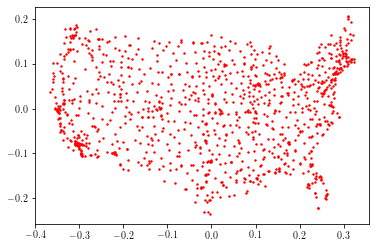

In [10]:
plt.scatter(data[:, 0], data[:, 1], s=2, c='red')
plt.savefig('../uscities_plots/us_data.png', format='png')
plt.show()

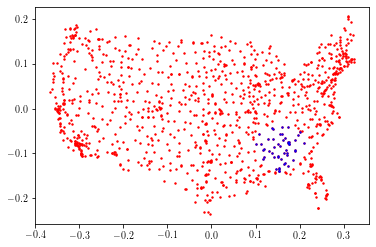

In [11]:
i = 0
plt.scatter(data[:, 0], data[:, 1], s=2, c='red')
plt.scatter(data[patch_indices[i], 0], data[patch_indices[i], 1], s=2, alpha=0.8, c='blue')
plt.savefig('../uscities_plots/us_k50_thres6_noiseless_patch'+str(i)+'.png', format='png')
plt.show()

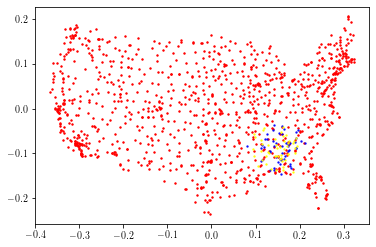

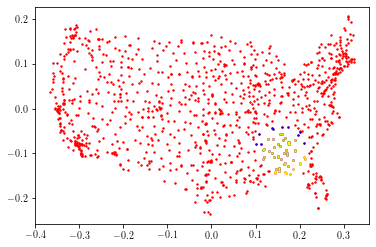

In [16]:
plt.scatter(data[:, 0], data[:, 1], s=2, c='red')
i = 0
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
rotated_coordinates = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i.T).T
plt.scatter(noisy_patch_i[:, 0], noisy_patch_i[:, 1], s=2, alpha=0.8, c='blue')
i = 2
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
rotated_coordinates = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i.T).T
plt.scatter(noisy_patch_i[:, 0], noisy_patch_i[:, 1], s=2, alpha=0.8, c='yellow')
plt.savefig('../uscities_plots/us_k50_thres6_100eta'+str(int(100*eta))+'patch0_1.png', format='png')
plt.show()
plt.scatter(data[:, 0], data[:, 1], s=2, c='red')
plt.scatter(data[patch_indices[0], 0], data[patch_indices[0], 1], s=2, alpha=0.8, c='blue')
plt.scatter(data[patch_indices[1], 0], data[patch_indices[1], 1], s=2, alpha=0.8, c='yellow')
plt.savefig('../uscities_plots/us_k50_thres6_noiseless_patch0_1.png', format='png')
plt.show()

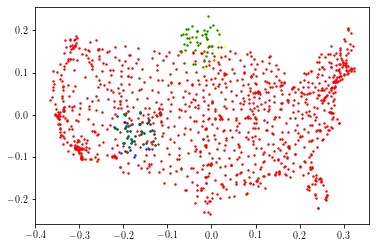

In [17]:
plt.scatter(data[:, 0], data[:, 1], s=2, c='red')
i = 0
j = 2
patch_i = patch_indices[i]
patch_j = patch_indices[j]
common_nodes = list(set(patch_i).intersection(set(patch_j)))
rot_mat_i = get_rotation_matrix(angles_gt[i]) # rotation matrix
rot_mat_j = get_rotation_matrix(angles_gt[j])
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
noisy_patch_j = data[patch_indices[j]].copy()
noisy_patch_j[:, 0] += added_noise_x[j]
noisy_patch_j[:, 1] += added_noise_y[j]
idx_i_sorted = np.argsort(patch_i)
common_nodes_pos = np.searchsorted(patch_i[idx_i_sorted], common_nodes)
indices_i = idx_i_sorted[common_nodes_pos]
idx_j_sorted = np.argsort(patch_j)
common_nodes_pos = np.searchsorted(patch_j[idx_j_sorted], common_nodes)
indices_j = idx_j_sorted[common_nodes_pos]
i = 0
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
rotated_coordinates = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i.T).T
plt.scatter(rotated_coordinates[:, 0], rotated_coordinates[:, 1], s=2, alpha=0.8, c='blue')
plt.scatter(rotated_coordinates[indices_i, 0], rotated_coordinates[indices_i, 1], s=2, alpha=0.8, c='green')
i = 2
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
rotated_coordinates = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i.T).T
plt.scatter(rotated_coordinates[:, 0], rotated_coordinates[:, 1], s=2, alpha=0.8, c='yellow')
plt.scatter(rotated_coordinates[indices_j, 0], rotated_coordinates[indices_j, 1], s=2, alpha=0.8, c='green')
plt.savefig('../uscities_plots/us_rorated_k50_thres6_100eta'+str(int(100*eta))+'patch0_1.png', format='png')
plt.show()

3.8748791 [3.90218142]
2.2581377 [2.25887579]


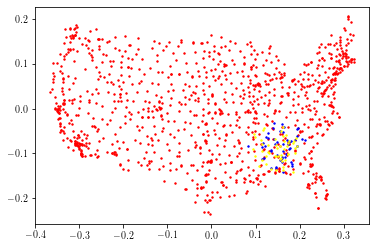

In [18]:
plt.scatter(data[:, 0], data[:, 1], s=2, c='red')
i = 0
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
rotated_coordinates = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i.T).T
rotated_coordinates = np.dot(get_rotation_matrix(-angles_pred[i]), rotated_coordinates.T).T
plt.scatter(rotated_coordinates[:, 0], rotated_coordinates[:, 1], s=2, c='blue')
print(angles_pred[i], angles_gt[i])
i = 2
noisy_patch_i = data[patch_indices[i]].copy()
noisy_patch_i[:, 0] += added_noise_x[i]
noisy_patch_i[:, 1] += added_noise_y[i]
rotated_coordinates = np.dot(get_rotation_matrix(angles_gt[i]), noisy_patch_i.T).T
rotated_coordinates = np.dot(get_rotation_matrix(-angles_pred[i]), rotated_coordinates.T).T
plt.scatter(rotated_coordinates[:, 0], rotated_coordinates[:, 1], s=2, c='yellow')
print(angles_pred[i], angles_gt[i])
plt.savefig('../uscities_plots/us_recovered_k50_thres6_100eta'+str(int(100*eta))+'patch0_1.png', format='png')
plt.show()

In [20]:
print(angles_pred[0]/np.pi*180, angles_pred[2]/np.pi*180, (angles_pred[0]-angles_pred[2])/np.pi*180)
print(angles_gt[0]/np.pi*180, angles_gt[2]/np.pi*180, (angles_gt[0]-angles_gt[2])/np.pi*180)
print(adj_obs[0,2]/np.pi*180)

222.0142198013756 129.38175993793698 92.63245986343863
[223.57852608] [129.4240492] [94.15447688]
88.42227336646796


In [21]:
print(angles_pred[0], angles_pred[2], (angles_pred[0]-angles_pred[2]))
print(angles_gt[0], angles_gt[2], (angles_gt[0]-angles_gt[2]))
print(adj_obs[0,2])

3.8748791 2.2581377 1.6167414
[3.90218142] [2.25887579] [1.64330563]
1.5432598023433566


In [26]:
print(eta*data[:, 0].std(), eta*data[:, 1].std())

0.010270178089654962 0.004881495288928255
